<a href="https://colab.research.google.com/github/rsradhakrishnan/handwritten-character-recognition/blob/main/handwritten_character_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Sep 22 07:18:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
from tensorflow.keras import Sequential
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD, RMSprop
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [ ]:
with open('/gdrive/My Drive/HTR/parser.txt') as f:
    content = f.readlines()

lines = [line.strip() for line in content] 
line =lines[0]

In [ ]:
max_label_len = 0

char_list = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

print(char_list, len(char_list))

def encode_to_labels(txt):
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst



abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 62


In [ ]:
images = []
labels = []

RECORDS_COUNT = 10000

In [ ]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

test_images = []
test_labels = []
test_input_length = []
test_label_length = []
test_original_text = []


inputs_length = []
labels_length = []

In [ ]:
def process_image(img):
    
    w, h = img.shape
    
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
  
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
  
    img = img / 255
    
    return img

In [ ]:
for index, line in tqdm(enumerate(lines)):
    splits = line.split(' ')
    status = splits[1]
    
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        
        splits_id = word_id.split('-')
        filepath = '/gdrive/My Drive/HTR/words/words/{}/{}-{}/{}.png'.format(splits_id[0], 
                                                  splits_id[0], 
                                                  splits_id[1], 
                                                  word_id)
        
        
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
            
       
        try:
            label = encode_to_labels(word)
        except:
            continue
        
        if index % 10 == 0:
            test_images.append(img)
            test_labels.append(label)
            test_input_length.append(31)
            test_label_length.append(len(word))
            test_original_text.append(word)
        
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        
        if len(word) > max_label_len:
            max_label_len = len(word)
    
    if index >= RECORDS_COUNT:
        break

10000it [36:13,  4.58it/s]

In [ ]:

train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

test_padded_label = pad_sequences(test_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

In [ ]:
train_padded_label.shape, test_padded_label.shape


((6763, 16), (772, 16))

In [ ]:
train_padded_label = np.array(train_padded_label)
train_images = np.array(train_images)
train_labels = np.array(train_labels)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

test_padded_label = np.array(test_padded_label)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
test_input_length = np.array(test_input_length)
test_label_length = np.array(test_label_length)

In [ ]:
np.savez('train_data.npz', train_padded_label=train_padded_label, train_images=train_images, train_labels=train_labels, train_input_length = train_input_length, train_label_length=train_label_length)

In [ ]:
np.savez('test_data.npz', test_padded_label=test_padded_label, test_images=test_images, test_labels=test_labels, test_input_length = test_input_length, test_label_length=test_label_length )

In [ ]:
!mv /content/test_data.npz /gdrive/My Drive/HTR/Data

mv: target 'Drive/HTR/Data' is not a directory


In [ ]:
inputs = Input(shape=(32,128,1))
 

conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)

pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 

blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)


act_model = Model(inputs, outputs)

In [ ]:
act_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 256)       

In [ ]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])


model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [ ]:
batch_size = 16
epochs = 35
e = str(epochs)
optimizer_name = SGD()

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="/gdrive/My Drive/HTR/Data/best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks_list)

Epoch 1/35
380/381 [============================>.] - ETA: 0s - loss: 0.0721 - accuracy: 0.9755
Epoch 00001: val_loss improved from inf to 8.03362, saving model to /gdrive/My Drive/HTR/Data/best_model.hdf5
381/381 [==============================] - 11s 30ms/step - loss: 0.0720 - accuracy: 0.9755 - val_loss: 8.0336 - val_accuracy: 0.3102
Epoch 2/35
379/381 [============================>.] - ETA: 0s - loss: 0.0570 - accuracy: 0.9804
Epoch 00002: val_loss improved from 8.03362 to 7.81852, saving model to /gdrive/My Drive/HTR/Data/best_model.hdf5
381/381 [==============================] - 10s 27ms/step - loss: 0.0569 - accuracy: 0.9804 - val_loss: 7.8185 - val_accuracy: 0.3250
Epoch 3/35
380/381 [============================>.] - ETA: 0s - loss: 0.0498 - accuracy: 0.9834
Epoch 00003: val_loss did not improve from 7.81852
381/381 [==============================] - 10s 26ms/step - loss: 0.0498 - accuracy: 0.9834 - val_loss: 7.9176 - val_accuracy: 0.3220
Epoch 4/35
380/381 [==================

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
original_text =   brought
predicted text = brought

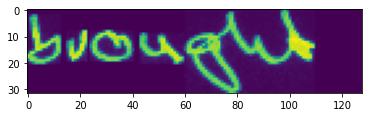



original_text =   life
predicted text = life

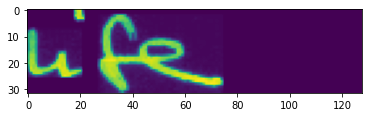



original_text =   peers
predicted text = peers

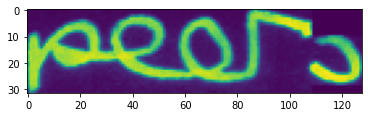



original_text =   into
predicted text = into

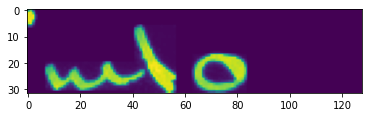



original_text =   existence
predicted text = existence

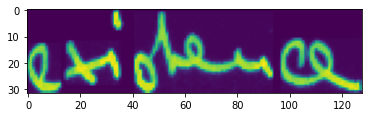



original_text =   they
predicted text = they

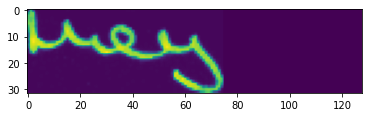



original_text =   not
predicted text = not

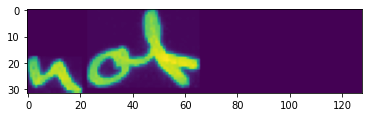



original_text =   now
predicted text = now

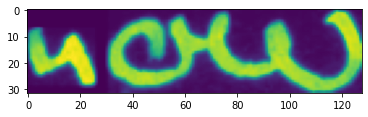



original_text =   put
predicted text = put

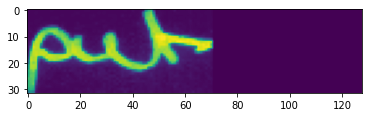



original_text =   forward
predicted text = forward

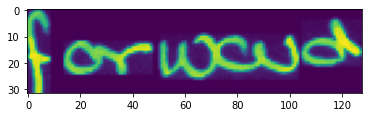



original_text =   nominees
predicted text = nominees

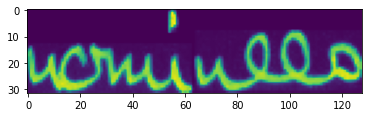



original_text =   He
predicted text = He

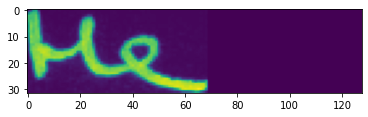



original_text =   believes
predicted text = believes

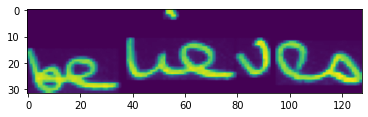



original_text =   that
predicted text = that

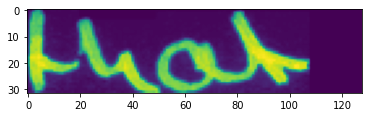



original_text =   House
predicted text = House

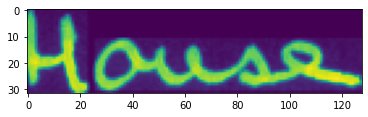



original_text =   of
predicted text = of

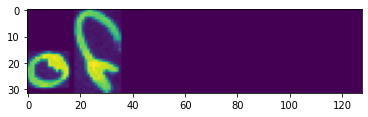



original_text =   Lords
predicted text = Lords

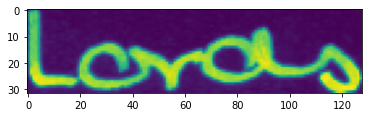



original_text =   should
predicted text = should

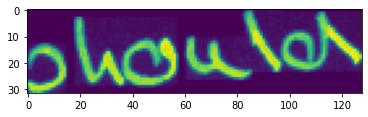



original_text =   be
predicted text = be

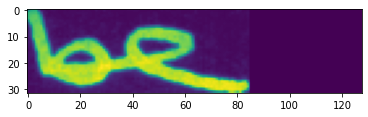



original_text =   abolished
predicted text = abolished

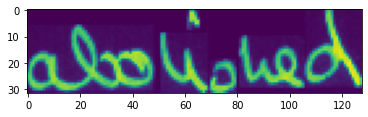

In [ ]:
prediction = act_model.predict(train_images[150:170])
 
# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1], greedy=True)[0][0]

out = K.get_value(decoded)


for i, x in enumerate(out):
    print("original_text =  ", train_original_text[150+i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(train_images[150+i].reshape(32,128))
    plt.show()
    print('\n')

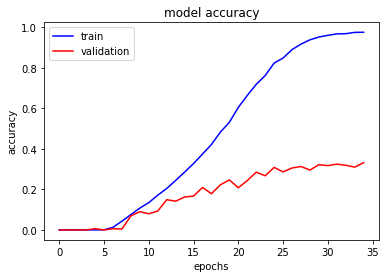

In [ ]:
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

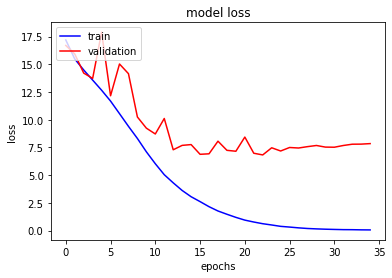

In [ ]:
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(x= [test_images, test_padded_label, test_input_length, test_label_length],
                              y=np.zeros(len(test_images)))

97/97 [==============================] - 1s 12ms/step - loss: 4.2439 - accuracy: 0.4896


In [ ]:
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 4.243928909301758
Test accuracy: 0.4896373152732849


original_text =   York
predicted text = toh

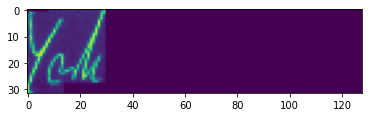



original_text =   there
predicted text = there

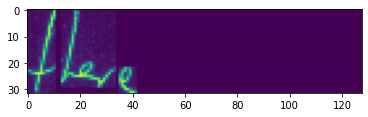



original_text =   projects
predicted text = prijects

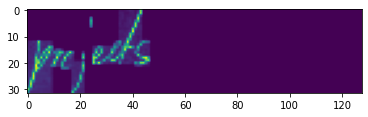



original_text =   opposition
predicted text = apponitin

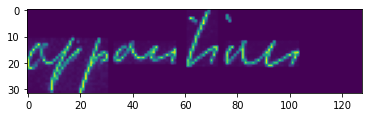



original_text =   Washington
predicted text = Wheuhrghen

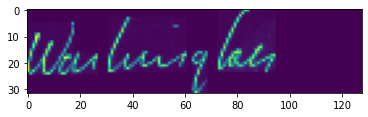



original_text =   The
predicted text = Th

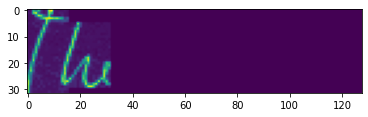



original_text =   Southern
predicted text = Sontheun

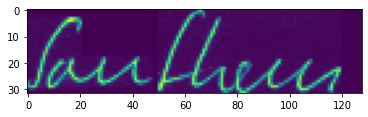



original_text =   today
predicted text = tolany

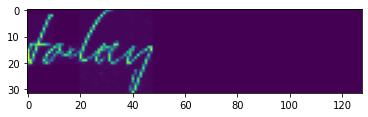



original_text =   Robertson
predicted text = loberbon

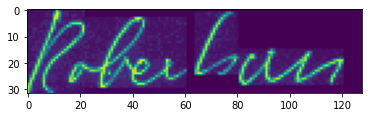



original_text =   Kennedy
predicted text = Kerneeday

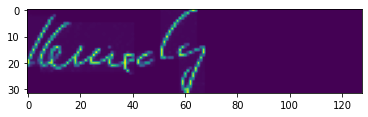



original_text =   the
predicted text = the

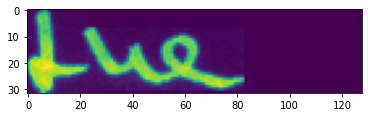



original_text =   current
predicted text = curent

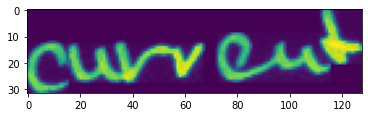



original_text =   another
predicted text = another

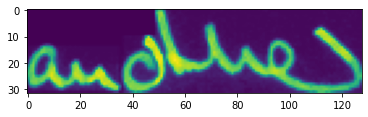



original_text =   met
predicted text = met

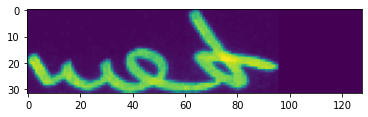



original_text =   television
predicted text = television

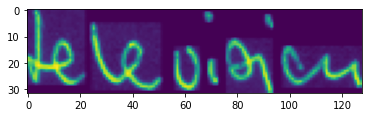



original_text =   Weaver
predicted text = Weadver

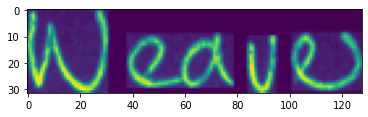



original_text =   Committee
predicted text = Coummtee

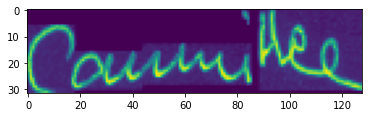



original_text =   Willis
predicted text = wilis

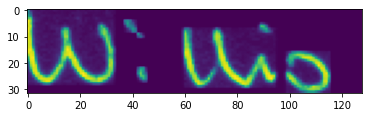



original_text =   he
predicted text = he

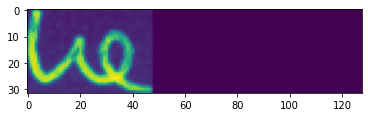



original_text =   had
predicted text = had

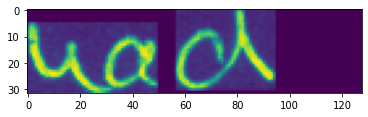

In [ ]:
prediction = act_model.predict(test_images[150:170])
 
# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1], greedy=True)[0][0]

out = K.get_value(decoded)


for i, x in enumerate(out):
    print("original_text =  ", test_original_text[150+i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(test_images[150+i].reshape(32,128))
    plt.show()
    print('\n')